In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
from math import log

sys.path.insert(0,'../')
from PhicoreModules import parse_genbank, mean, median, mode, visualise
from PhicoreModules import parse_genbank, median, mean, stdev, mode
from PhicoreModules import get_features_of_type, get_features_lengths, get_gc_content, get_coding_density, get_distribution_of_stops # Przemek's functions
from PhicoreModules import get_mean_cds_length_rec_window, get_rolling_gc, get_rolling_mean_cds # George's functions
from PhicoreModules import write_df_to_artemis, non_overlapping_kmers

# Fixed issue that windows were not multiples of 3 

In [2]:
def calc_coding_density(filestub='Bc01.fasta', gbkdir = '../genbank/'):
    for file in os.listdir(gbkdir):
        if not filestub in file:
            continue
        df = get_distribution_of_stops(record, window=210, step=1)

In [56]:
def stop_entropy_per_strand(entry: Bio.SeqRecord.SeqRecord, strand: int = 1, window: int = 1000, step: int = 1, codons = ["TAG", "TAA", "TGA"], verbose: bool = False) -> list[int]:
    """
    Calculate the stops per strand of the sequence
    
    :param entry: the genbank entry
    :param strand: an int {-3, -2, -1, 1, 2, 3}. If the int is -ve we will reverse complement
    :param window: the window size to use
    :param step: the interval between windows
    :param verbose: more output (to stderr)
    :return: a list with the frequency per window
    """
    
    if strand > 3 or strand < -3 or strand == 0:
        print(f"Strand must be an int of -3, -2, -1, 1, 2, 3", file=sys.stderr)
        return None
    
    if window % 3:
        print("Please make window a multiple of 3", file=sys.stderr)
        return None
    
    if step % 3: 
        print("Please make step a multiple of 3", file=sys.stderr) 
    
    s = str(entry.seq).upper()
    posn = strand
    
    #reverse complement 
    if strand < 0:
        s = str(entry.seq.reverse_complement().upper())
        posn  = -strand #switching so that the posn is not negative 
    
    print(f"Start of {strand} is {s[posn:10]}", file=sys.stderr)
    result = {}
    while (posn+window+step) < len(s):
        w = s[posn:posn+window]
        entropy = 0
        kmers =  non_overlapping_kmers(w, 3)
        stopcodon_kmers = [kmers.count(c) for c in codons]
        for n in stopcodon_kmers: #these are the top codons it is counting - will need to toggle this? 
            pri = n / ( (window/3)  )
            if pri > 1 or pri < 0: 
                print(pri)
            #pri = n / ( (window/3) )
            #window/3 refers to the number of codons in the window 
            if posn<5: #give updates for the first few  
                print(f"{strand}\t{posn}\t{n}\t{pri}", file=sys.stderr)
            entropy += pri * log(pri+sys.float_info.epsilon) #need to include epsilon in case of no stop codons 
        result[posn-strand] = -entropy
        posn += step
    
    return result
        
        
def stop_entropy_all_strands(file, window: int = 1000, step: int = 1, codons = ["TAG", "TAA", "TGA"]): 
    """ 
    Return the stops for each strand for a genome 
    """ 
    
    nats = pd.DataFrame()
    #record = ''
    for record in parse_genbank(file):
        for i in [1, 2, 3, -1, -2, -3]:
            print(f"Calculating entropy for {i}", file=sys.stderr)
            data = stop_entropy_per_strand(record, strand=i, window=3996, step=step, codons = codons)
            if not data:
                print(f"Bugger {i}", file=sys.stderr)
            if nats.empty:
                nats = pd.DataFrame.from_dict(data, orient='index',columns=[i]).reset_index()
                nats = nats.rename(columns={'index': 'x'})
            else:
                nats[i] = nats['x'].map(data)
                
    return nats

def plot_stop_entropy(df): 
    """ 
    Make a pretty plot of the stop codon entropy 
    """ 
    
    g = df[['x',1,2,3]].plot(x='x', figsize=(20, 4))
    t = g.set_xlabel('Position in genome (bp)')
    t = g.set_ylabel('Stop codon entropy')


In [59]:
#Both both with all three stop codons 
Bc01 = '../genbank/Bc01.fasta-TAG-TGA-TAA.gbk'
Bc01_stop_entropy = stop_entropy_all_strands(Bc01, 3000, 3, codons = ["TAG", "TAA", "TGA"]) 
cr150 = '../genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk'
cr150_stop_entropy = stop_entropy_all_strands(cr150, 3000, 3, codons = ["TAG", "TAA", "TGA"]) 

Calculating entropy for 1
Start of 1 is GCAGAAGAG
1	1	20	0.015015015015015015
1	1	17	0.012762762762762763
1	1	16	0.012012012012012012
1	4	20	0.015015015015015015
1	4	17	0.012762762762762763
1	4	16	0.012012012012012012
Calculating entropy for 2
Start of 2 is CAGAAGAG
2	2	34	0.025525525525525526
2	2	69	0.0518018018018018
2	2	63	0.0472972972972973
Calculating entropy for 3
Start of 3 is AGAAGAG
3	3	11	0.008258258258258258
3	3	41	0.03078078078078078
3	3	40	0.03003003003003003
Calculating entropy for -1
Start of -1 is CAGTAACAA
-1	1	14	0.010510510510510511
-1	1	31	0.023273273273273273
-1	1	22	0.016516516516516516
-1	4	14	0.010510510510510511
-1	4	31	0.023273273273273273
-1	4	22	0.016516516516516516
Calculating entropy for -2
Start of -2 is AGTAACAA
-2	2	23	0.017267267267267267
-2	2	38	0.028528528528528527
-2	2	27	0.02027027027027027
Calculating entropy for -3
Start of -3 is GTAACAA
-3	3	19	0.014264264264264264
-3	3	37	0.027777777777777776
-3	3	24	0.018018018018018018
Calculating entropy for

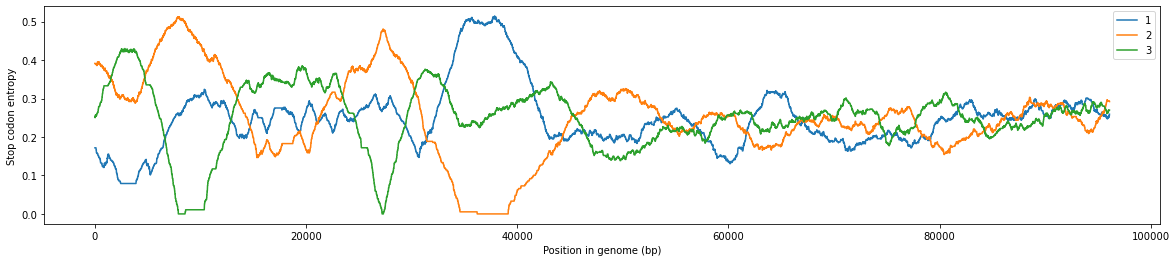

In [60]:
plot_stop_entropy(Bc01_stop_entropy)

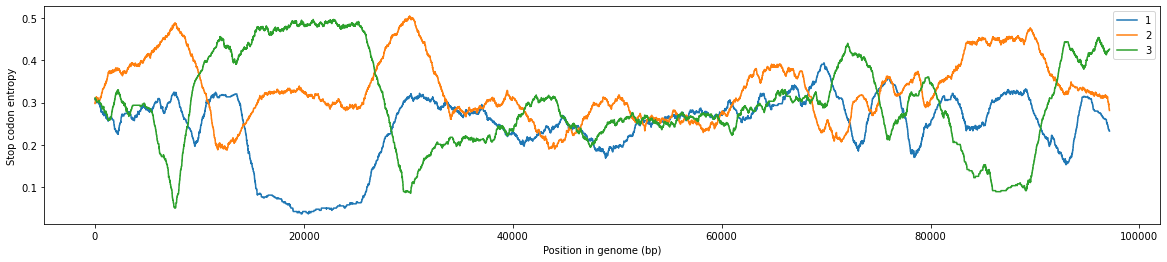

In [61]:
plot_stop_entropy(cr150_stop_entropy)

In [47]:
#just one stop codon
Bc01 = '../genbank/Bc01.fasta-TAG-TGA-TAA.gbk'
Bc01_stop_entropy = stop_entropy_all_strands(Bc01, 3000, 3, codons = ["TAG"]) 
cr150 = '../genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1.fasta-TGA-TAA.gbk'
cr150_stop_entropy = stop_entropy_all_strands(cr150, 3000, 3, codons = ["TAG"]) 

/home/grig0076/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       cluster_001_consensus    100102 bp    DNA             PHG\n'
  warnings.warn(
Calculating entropy for 1
Start of 1 is GCAGAAGAG
1	1	20	0.015015015015015015
1	4	20	0.015015015015015015
Calculating entropy for 2
Start of 2 is CAGAAGAG
2	2	34	0.025525525525525526
Calculating entropy for 3
Start of 3 is AGAAGAG
3	3	11	0.008258258258258258
Calculating entropy for -1
Start of -1 is CAGTAACAA
-1	1	14	0.010510510510510511
-1	4	14	0.010510510510510511
Calculating entropy for -2
Start of -2 is AGTAACAA
-2	2	23	0.017267267267267267
Calculating entropy for -3
Start of -3 is GTAACAA
-3	3	19	0.014264264264264264
/home/grig0076/.local/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1554: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(
C

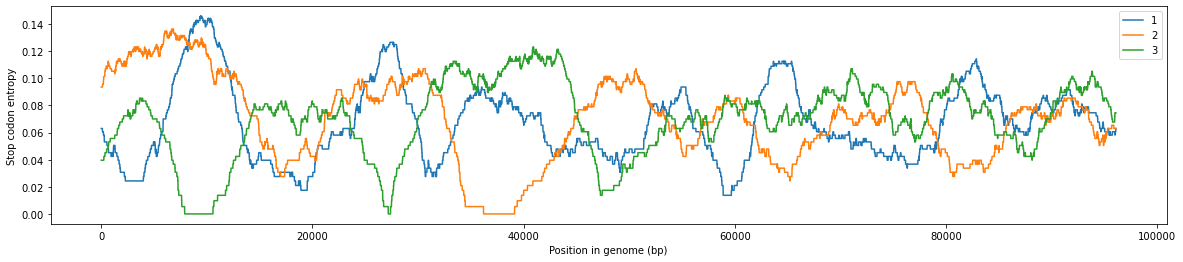

In [57]:
plot_stop_entropy(Bc01_stop_entropy)

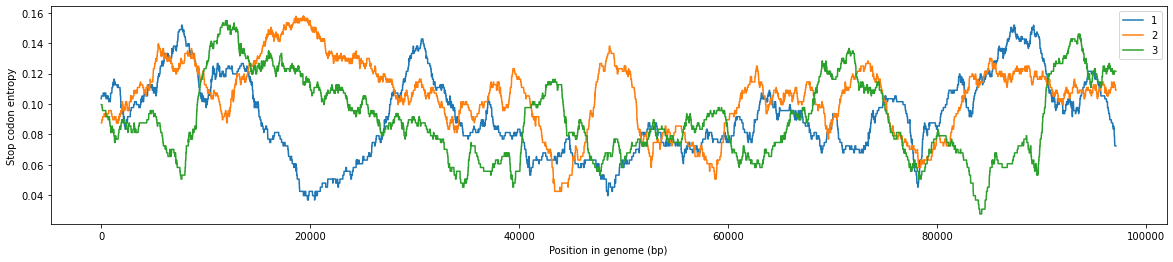

In [58]:
plot_stop_entropy(cr150_stop_entropy)